# XG Boost Regressor

## Importing the libraries

In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Importing the dataset

In [49]:
# pyspark_df = spark.table("sd_bdc_demo.xgboost_regression.2_salesforce_xgboost_updated_data")
# pyspark_df.display()
# df = pyspark_df.toPandas()

In [50]:
# Load csv file
df = pd.read_csv("2_salesforce_xgboost_updated_data/2_salesforce_xgboost_updated_data.csv")

In [51]:
print(df)

    Sales_Order                 Stage  Amount  Probability    Sales_Person  \
0          5708           Closed Lost  255000           40  Alex Rodriguez   
1          5709       Decision Makers  315000           70   Sarah Johnson   
2          5710  Proposal/Price Quote  275000           65   Michael Chang   
3          5711            Closed Won  135000           68     Emma Wilson   
4          5712    Negotiation/Review  325000           85  David Martinez   
..          ...                   ...     ...          ...             ...   
91         5799   Perception Analysis  475000           25  Alex Rodriguez   
92         5800     Value Proposition  115000           40   Sarah Johnson   
93         5801         Qualification   95000           20   Michael Chang   
94         5802            Closed Won   68000           76     Emma Wilson   
95         5803        Needs Analysis  185000           35  David Martinez   

      Company_Industry              Contact_Title          Type

In [52]:
print(df.shape)

(96, 11)


In [53]:
print(df.columns)

Index(['Sales_Order', 'Stage', 'Amount', 'Probability', 'Sales_Person',
       'Company_Industry', 'Contact_Title', 'Type', 'Lead_Source', 'State',
       'days_to_close'],
      dtype='object')


In [54]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Sales_Order       96 non-null     int64 
 1   Stage             96 non-null     object
 2   Amount            96 non-null     int64 
 3   Probability       96 non-null     int64 
 4   Sales_Person      96 non-null     object
 5   Company_Industry  96 non-null     object
 6   Contact_Title     96 non-null     object
 7   Type              96 non-null     object
 8   Lead_Source       96 non-null     object
 9   State             96 non-null     object
 10  days_to_close     96 non-null     int64 
dtypes: int64(4), object(7)
memory usage: 8.4+ KB
None


## Encoding categorical data

### Encoding the Independent Variable

In [55]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
categorical_cols = [
    'Sales_Person',
    'Company_Industry',
    'Contact_Title',
    'Type',
    'Lead_Source',
    'State'
]

# Save encoder for later use
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  


In [56]:
print(df_encoded.head())

   Sales_Order                 Stage  Amount  Probability  Sales_Person  \
0         5708           Closed Lost  255000           40             0   
1         5709       Decision Makers  315000           70             4   
2         5710  Proposal/Price Quote  275000           65             3   
3         5711            Closed Won  135000           68             2   
4         5712    Negotiation/Review  325000           85             1   

   Company_Industry  Contact_Title  Type  Lead_Source  State  days_to_close  
0                12             29     0            5     42             45  
1                11             20     0           14     23             97  
2                 8              8     0            6     39            117  
3                19             28     0           16     31             36  
4                15             41     0           10     29             92  


In [57]:
print(df_encoded.shape)

(96, 11)


In [58]:
print(df_encoded.columns)

Index(['Sales_Order', 'Stage', 'Amount', 'Probability', 'Sales_Person',
       'Company_Industry', 'Contact_Title', 'Type', 'Lead_Source', 'State',
       'days_to_close'],
      dtype='object')


## Split two Data Frame for Independent Features & Dependent Columns

In [59]:
df_independent = df_encoded.drop(columns=['Probability'])
X = df_independent
df_dependent = df_encoded[['Probability']]
y = df_dependent

In [60]:
print(df_independent.head())

   Sales_Order                 Stage  Amount  Sales_Person  Company_Industry  \
0         5708           Closed Lost  255000             0                12   
1         5709       Decision Makers  315000             4                11   
2         5710  Proposal/Price Quote  275000             3                 8   
3         5711            Closed Won  135000             2                19   
4         5712    Negotiation/Review  325000             1                15   

   Contact_Title  Type  Lead_Source  State  days_to_close  
0             29     0            5     42             45  
1             20     0           14     23             97  
2              8     0            6     39            117  
3             28     0           16     31             36  
4             41     0           10     29             92  


In [61]:
print(df_independent.shape)

(96, 10)


In [62]:
print(df_dependent.head())

   Probability
0           40
1           70
2           65
3           68
4           85


In [63]:
print(df_dependent.shape)

(96, 1)


## Splitting the dataset into the Training set and Test set (`Closed Won` & `Closed Lost` = `train`)

In [64]:
# Define which rows go into train and test based on 'Stage'
is_train = df_encoded['Stage'].isin(['Closed Won', 'Closed Lost'])

# Split X
X_train = X[is_train] 
X_test = X[~is_train]

# Split y
y_train = y[is_train]
y_test = y[~is_train]  


### Splitting part of test data to train data

In [65]:
from sklearn.model_selection import train_test_split
X_train_ren, X_test_ren, y_train_ren, y_test_ren = train_test_split(X_test, y_test, test_size = 0.2, random_state = 1)

In [66]:
X_train = pd.concat([X_train, X_train_ren])
y_train = pd.concat([y_train, y_train_ren])

X_test = X_test_ren
y_test = y_test_ren

In [67]:
print(X_train.head())

    Sales_Order        Stage  Amount  Sales_Person  Company_Industry  \
0          5708  Closed Lost  255000             0                12   
3          5711   Closed Won  135000             2                19   
8          5716   Closed Won  235000             2                12   
12         5720   Closed Won  225000             2                 8   
17         5725   Closed Won  175000             2                12   

    Contact_Title  Type  Lead_Source  State  days_to_close  
0              29     0            5     42             45  
3              28     0           16     31             36  
8               4     2            5     38             36  
12             11     2            4     24             38  
17             48     2            5     21             40  


In [68]:
print(X_train.shape)

(81, 10)


In [69]:
print(X_test.head())

    Sales_Order                 Stage  Amount  Sales_Person  Company_Industry  \
88         5796  Proposal/Price Quote  235000             3                22   
34         5742         Qualification  225000             3                22   
91         5799   Perception Analysis  475000             0                12   
74         5782        Needs Analysis  230000             2                 9   
36         5744        Needs Analysis  385000             1                15   

    Contact_Title  Type  Lead_Source  State  days_to_close  
88             33     0           18      8             96  
34             16     0            6     25            143  
91             30     2            6     33            148  
74             50     0            6     37             96  
36             32     0           11     42            141  


In [70]:
print(X_test.shape)

(15, 10)


In [71]:
print(y_train.head())

    Probability
0            40
3            68
8            48
12           71
17           75


In [72]:
print(y_train.shape)

(81, 1)


In [73]:
print(y_test.head())

    Probability
88           60
34           30
91           25
74           25
36           35


In [74]:
print(y_test.shape)

(15, 1)


## Feature Scaling
- As this is a tree based model, no need to do feature scaling

## Removing `Sales_Order` & `Stage` in `X_train` & `X_test`

In [75]:
X_train_new = X_train.drop(columns=['Sales_Order', 'Stage', 'Sales_Person'])


In [76]:
print(X_train_new.head())

    Amount  Company_Industry  Contact_Title  Type  Lead_Source  State  \
0   255000                12             29     0            5     42   
3   135000                19             28     0           16     31   
8   235000                12              4     2            5     38   
12  225000                 8             11     2            4     24   
17  175000                12             48     2            5     21   

    days_to_close  
0              45  
3              36  
8              36  
12             38  
17             40  


In [77]:
print(X_train_new.shape)

(81, 7)


In [78]:
X_test_new = X_test.drop(columns=['Sales_Order', 'Stage', 'Sales_Person'])


In [79]:
print(X_test_new.head())

    Amount  Company_Industry  Contact_Title  Type  Lead_Source  State  \
88  235000                22             33     0           18      8   
34  225000                22             16     0            6     25   
91  475000                12             30     2            6     33   
74  230000                 9             50     0            6     37   
36  385000                15             32     0           11     42   

    days_to_close  
88             96  
34            143  
91            148  
74             96  
36            141  


In [80]:
print(X_test_new.shape)

(15, 7)


## Training the Model

In [81]:
from xgboost import XGBRegressor

# Initialize the model
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)


### RFE

In [82]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=xgb_model, n_features_to_select=5)
rfe.fit(X_train_new, y_train)

# selected features after RFE
selected_features = X_train_new.columns[rfe.support_]
print(selected_features)

Index(['Amount', 'Company_Industry', 'Lead_Source', 'State', 'days_to_close'], dtype='object')


In [83]:
# take only selected columns for both X_train_new & X_test_new
X_train_new = X_train_new[selected_features]
X_test_new = X_test_new[selected_features]
xgb_model_train = xgb_model.fit(X_train_new, y_train.values.ravel())


## Prediction

In [84]:
y_pred = xgb_model.predict(X_test_new)

In [85]:
print(y_pred)

[61.66782  30.185387 31.575035 57.386623 35.252525 40.284016 68.89685
 35.534252 34.38298  42.688618 80.71994  40.958324 71.36646  69.89162
 31.98812 ]


### Saving the output as new table

In [86]:
sales_order = X_test['Sales_Order'].values
stage = X_test['Stage'].values

In [87]:
print("sales_order shape:", sales_order.shape)
print("stage shape:", stage.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)


sales_order shape: (15,)
stage shape: (15,)
y_test shape: (15, 1)
y_pred shape: (15,)


In [88]:
print(y_test)

    Probability
88           60
34           30
91           25
74           25
36           35
82           35
66           30
48           60
65           30
41           15
4            85
52           40
73           40
47           75
58           65


In [89]:
# Flatten y_test to 1D
y_test = y_test.values.ravel()

In [90]:
print("sales_order shape:", sales_order.shape)
print("stage shape:", stage.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)


sales_order shape: (15,)
stage shape: (15,)
y_test shape: (15,)
y_pred shape: (15,)


In [91]:
print(y_test)

[60 30 25 25 35 35 30 60 30 15 85 40 40 75 65]


In [92]:
print(y_pred)

[61.66782  30.185387 31.575035 57.386623 35.252525 40.284016 68.89685
 35.534252 34.38298  42.688618 80.71994  40.958324 71.36646  69.89162
 31.98812 ]


In [93]:
results_df = pd.DataFrame({
    'sales_order': sales_order,
    'stage': stage,
    'Actual': y_test,
    'Predicted': y_pred
})


In [94]:
# Create the folder if it doesn't exist
os.makedirs("3_1_salesforce_xgboost_prediction_data", exist_ok=True)

# Save the Excel file inside the folder
results_df.to_csv("3_1_salesforce_xgboost_prediction_data/3_1_salesforce_xgboost_prediction_data.csv", index=False)


In [95]:
# spark_df = spark.createDataFrame(results_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.xgboost_regression.3_1_salesforce_xgboost_prediction_data")

## Accuracy

In [96]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

print("r2:\n", r2_score(y_test, y_pred))
print("MAE:\n", mean_absolute_error(y_test, y_pred))
print("RMSE:\n", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAPE:\n", mean_absolute_percentage_error(y_test, y_pred))

r2:
 -0.034714341163635254
MAE:
 14.43404769897461
RMSE:
 20.230843230628466
MAPE:
 0.45876142382621765


In [97]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


MAPE: 45.88%
Accuracy: 54.12%


## Applying k-Fold Cross Validation

### Shuffled

In [98]:
from sklearn.model_selection import cross_val_score, KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results = cross_val_score(xgb_model, X=X_train_new, y=y_train, cv=kf)

In [99]:
print("Cross-Validation Results (Accuracy):")
for i, result in enumerate(cross_val_results, 1):
    print(f"  Fold {i}: {result * 100:.2f}%")

print("Kfold Mean ccuracy: {:.2f} %".format(cross_val_results.mean()*100))
print("Standard Deviation: {:.2f} %".format(cross_val_results.std()*100))

Cross-Validation Results (Accuracy):
  Fold 1: -9.99%
  Fold 2: 64.05%
  Fold 3: 52.93%
  Fold 4: 30.32%
  Fold 5: -6.58%
Kfold Mean ccuracy: 26.15 %
Standard Deviation: 30.16 %


### Unshuffled

In [100]:

accuracies = cross_val_score(estimator = xgb_model, X = X_train_new, y = y_train, cv = 5)
print("Kfold Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Kfold Accuracy: 16.81 %
Standard Deviation: 66.60 %


## Feature Importance with `shap`

In [101]:
print(xgb_model_train.feature_importances_)


[0.12703599 0.10506734 0.15288836 0.16184272 0.45316553]


c:\Users\LakshmanNavaneethakr\Downloads\lakshmansierra-git\poc_xg_boost\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'shap._explanation.Explanation'>


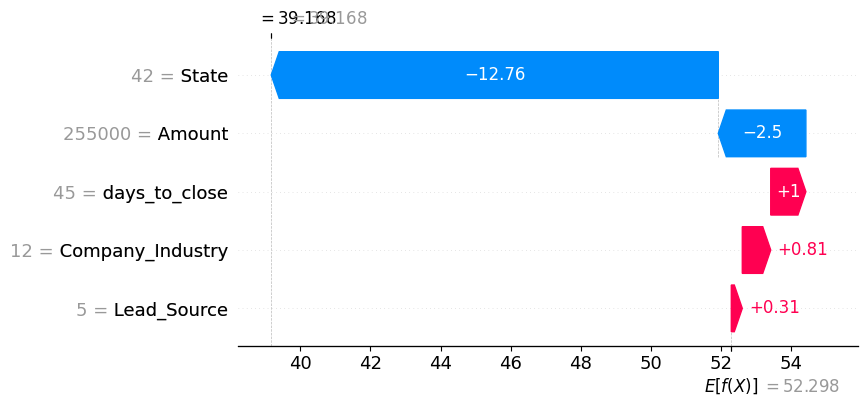

In [102]:
import shap 

explainer = shap.Explainer(xgb_model_train)
shap_values = explainer(X_train_new)
print(type(shap_values))
shap.plots.waterfall(shap_values[0])

In [103]:
print(shap_values)

.values =
array([[-2.49959779e+00,  8.11753273e-01,  3.13336700e-01,
        -1.27588415e+01,  1.00354958e+00],
       [-8.81593078e-02,  1.86567828e-01,  2.45369458e+00,
         4.27829933e+00,  8.86170197e+00],
       [-2.18787169e+00,  8.29771280e-01,  5.91442943e-01,
        -7.71492624e+00,  4.76188946e+00],
       [-1.75203657e+00,  3.68643498e+00,  9.88635004e-01,
         3.65970278e+00,  1.18951874e+01],
       [-1.42346287e+00,  1.01580894e+00,  1.02952015e+00,
         4.15189791e+00,  1.52955084e+01],
       [-9.37137485e-01,  3.27221942e+00,  8.01811159e-01,
         3.83695674e+00,  1.37162085e+01],
       [-3.53496218e+00,  4.15085745e+00,  3.81044358e-01,
        -1.11021948e+01,  4.52759552e+00],
       [-1.64357316e+00, -9.89652920e+00,  1.34790182e-01,
         2.65523767e+00,  1.25104809e+01],
       [ 1.91710258e+00,  6.97147012e-01,  4.02445704e-01,
         2.32211566e+00,  1.01165094e+01],
       [-2.31073126e-01,  4.01168108e+00,  6.12325907e-01,
         2.48

In [104]:
import pandas as pd
importance_df = pd.DataFrame({
    "Feature": X_train_new.columns,
    "Mean SHAP Value": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="Mean SHAP Value", ascending=False)

print(importance_df)


            Feature  Mean SHAP Value
4     days_to_close        13.497792
0            Amount         3.749719
1  Company_Industry         2.567211
3             State         2.494538
2       Lead_Source         1.888485


### Export Feature Importance

In [105]:
# Create the folder if it doesn't exist
os.makedirs("3_2_salesforce_feature_importance_data", exist_ok=True)

# Save the Excel file inside the folder
importance_df.to_csv("3_2_salesforce_feature_importance_data/3_2_salesforce_feature_importance_data.csv", index=False)


In [106]:
# spark_df = spark.createDataFrame(importance_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.xgboost_regression.3_2_salesforce_feature_importance_data")